In [2]:
import numpy as np                             # viva numpy!
from scipy.integrate import RK45 as integrator # integrator | odeint / RK45
import matplotlib.pyplot as plt                # visualization util

In [3]:
def alpha_calc(q): # phi?
#     alpha = (np.pi - phi) + ( q[0] - q[1] )/2 # my calc
    
    # from Spong
    alpha =  ( q[0] - q[1] )/2 

#     alpha = (2*np.pi) - ( q[0] + q[1] )/2
    
    return alpha

State-space: 
$$
    q = [ \theta, \ \dot \theta ]^T = [ \theta_{ns}, \theta_{s}, \ \dot \theta_{ns}, \dot \theta_{s} ]^T
$$

The swing stage equations of the robot similar to that of a frictionless double pendulum  can be written as :
$$
    M(\theta) \ddot \theta + N(\theta, \dot \theta) \dot \theta + \frac{1}{a} g(\dot \theta) = 0
$$

Normalazed peremeters $ \mu, \beta $ for matrixes:

$$
    M(\theta) =
    \begin{pmatrix}
        \beta^2 & -(1 + \beta) \beta \cos 2 \alpha \\
        -(1 + \beta) \beta \cos 2 \alpha & (1 + \beta)^2 (\mu + 1) + 1
    \end{pmatrix}
$$

In [4]:
def M(q, mu, beta, phi):
#     print(q[0], q[1], q[1], q[3])
    alpha = alpha_calc(q)
    M_11 = beta*beta
    M_12 = -(1+beta)*beta*np.cos(2*alpha)
    M_21 = M_12
    M_22 = (1+beta)*(1+beta)*(mu+1) + 1
    return np.array([[M_11, M_12],
                     [M_21, M_22]])

$$
    N(\theta, \dot \theta) =
    \begin{pmatrix}
        0 & (1 + \beta) \beta \dot \theta_{ns} sin(\theta_{s} - \theta_{ns}) \\
        -(1 + \beta) \beta \dot \theta_{ns} sin(\theta_{s} - \theta_{ns}) & 0
    \end{pmatrix}
$$

In [5]:
def N(q, mu, beta):
    N_11 = 0
    N_12 = (1+beta)*beta*q[2]*np.sin( q[1] - q[0] )
    N_21 = -N_12
    N_22 = 0
    return np.array([[N_11, N_12],
                     [N_21, N_22]])

$$
    g(\theta) =
    \begin{pmatrix}
        g \beta \sin \theta_{ns}  \\
        -( (\mu + 1)(1 + \beta) + 1 ) g \sin \theta_{s}
    \end{pmatrix}
$$

In [6]:
def g(q, mu, beta):
    _g_const = 9.81
    N_11 = _g_const * beta * np.sin( q[0] )
    N_21 = -( (mu + 1)*(1 + beta) + 1 ) * _g_const * np.sin( q[1] )
    return np.array([[N_11],
                     [N_21]])

$$
   - M(\theta) \ddot \theta =  N(\theta, \dot \theta) \dot \theta + \frac{1}{a} g(\dot \theta)
$$

Since $ \mu \in [0.1; 10] $ and $ \beta \in [0.1; 10] $, $ M(\theta)^{-1} $ exists, so

$$
     \ddot \theta = - M(\theta)^{-1} ( N(\theta, \dot \theta) \dot \theta + \frac{1}{a} g(\dot \theta) )
$$

Using $ z = \dot \theta $:

$$
    q = [\theta, z]
$$

$$
    \dot q = [z, - M(\theta)^{-1} ( N(\theta, z) z + \frac{1}{a} g(z) ) ]
$$

Finally, contact model. 

$$
    W(\alpha) =
    \begin{pmatrix}
        J & 0 \\
        0 & H(\alpha)
    \end{pmatrix} =
    \begin{pmatrix}
        J & 0 \\
        0 & ( Q^{+}(\alpha) )^{-1} Q^{-}(\alpha) 
    \end{pmatrix}
$$

$$
   J =
    \begin{pmatrix}
        0 & -1 \\
        1 & 0
    \end{pmatrix}
$$

$$
    Q^{-}(\alpha) =
    \begin{pmatrix}
        -\beta & -\beta + ( \mu(1 + \beta)^2 + 2(1 + \beta) ) \cos 2 \alpha \\
        0 & -\beta
    \end{pmatrix}
    , \quad
    Q^{+}(\alpha) =
    \begin{pmatrix}
        \beta( \beta - (1 + \beta) \cos 2 \alpha ) & (1 + \beta)( (1 + \beta) - \beta \cos 2 \alpha ) + 1 + \mu(1 + \beta)^2
        \\
        \beta^2 & -\beta ( 1 + \beta) \cos 2 \alpha
    \end{pmatrix}
$$

In [7]:
def W(q, mu, beta, phi):
    alpha = alpha_calc(q)
    
    q_m_11 = -beta
    q_m_12 = -beta + ( mu*(1 + beta)*(1 + beta) + 2*(1 + beta)) * np.cos(2*alpha)
    q_m_22 = -beta
    Q_m = np.array([[q_m_11, q_m_12],
                    [0.    , q_m_22]])
    q_p_11 = beta*( beta - (1 + beta)*np.cos(2*alpha) )
    q_p_12 = (1 + beta)*( (1 + beta) - beta*np.cos(2*alpha) ) + 1 + mu*(1 + beta)*(1 + beta)
    q_p_21 = beta*beta
    q_p_22 = -beta*(1 + beta)*np.cos(2*alpha)
    Q_p = np.array([[q_p_11, q_p_12],
                    [q_p_21, q_p_22]])
    
    print(Q_p)
    H_a = np.linalg.inv(Q_p) @ Q_m
    
    J = np.array([[0, -1],
                  [1,  0]])
    
    O = np.zeros([2, 2])
    
    return np.bmat([[J, O],
                    [O, H_a]])
#     return H_a

In [33]:
# Model params
mu   = 2      # 0.1 ... 10
beta = 2      # 0.1 ... 10
phi  = 0.0525 # rad
l    = 1      # m

# Initial state vector
theta_ns_0 = 0.0     # swing leg   (ussually positive)
theta_s_0  = 0.0     # support leg
dot_theta_ns_0 = 0.4
dot_theta_s_0  = 2.0

In [10]:
W([0.02476901, 0.02357954, 0.01197277, 0.11945023], mu=mu, beta=beta, phi=phi)

[[-1.19999813 12.88000187]
 [ 1.44       -2.63999813]]


matrix([[ 0.        ,  1.        ,  0.        ,  0.        ],
        [ 1.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        , -0.20599223,  1.20598832],
        [ 0.        ,  0.        , -0.11235948,  1.11235805]])

In [11]:
q = [0.02476901, 0.02357954, 0.01197277, 0.11945023]
_W = W(q, mu=mu, beta=beta, phi=phi)
q = (_W @ np.asarray([q]).T)
q = np.asarray(q.T)[0]

print(q)

[[-1.19999813 12.88000187]
 [ 1.44       -2.63999813]]
[0.02357954 0.02476901 0.14158928 0.13152617]


In [26]:
def contact_estimator(q, phi):
    alpha = alpha_calc(q)
    ## plan 1
#     gamma = np.pi - alpha
#     return q[0] + gamma - phi

    # plan 2
    q_s = q[1]
    q_a = q_s - (np.pi - 2*alpha)
    
    x = l * np.sin(-q_s) + l * np.sin(-q_a)
    y = l * np.cos(q_s) + l * np.cos(q_a)
    
#     res = np.arctan2(y, x) - phi
    res = y - x*np.tan(phi)

    ## plan 3 
    if abs(alpha)>0.02 and abs((alpha)-2*np.pi)>0.02:
        return res
#         return (q[0] + q[1])/2 - phi 
    else:
        return 10.

on_switch = False
def touch_detector(q, phi):
    global on_switch
    EPS = 0.075
    
    if on_switch and abs( contact_estimator(q, phi) ) > 2*EPS:
        on_switch = False
    
#     if abs(q[1] + alpha - 2*np.pi)<EPS : # a
#     if abs( (q[0] + q[1])/2 - phi )<EPS and ( abs(alpha)<EPS or (abs(alpha)-2*np.pi)<EPS ): # b
    if (not on_switch) and abs( contact_estimator(q, phi) ) < EPS:
        return 1
        on_switch = True
    else:
        return 0

In [ ]:

# _M @ z_dot = -( _N @ z + a_inv*_g ) 

# solutions = np.linalg.solve(LHS, RHS)

Early success bellow

In [14]:
# z_dot = - _M_inv @ ( _N @ z + a_inv*_g ) 

# solutions = np.linalg.solve(_M, _N @ z + a_inv*_g)

# print(solutions)  # prints the solutions for each system

zero crossing at 0.05180000000000004 with  q: [ 0.02340222 -0.01705959  0.50350984  1.99354504]
[[-1.99502471 22.00497529]
 [ 4.         -5.99502471]]
restarted at state:  [-0.01722366  0.02350297  2.22072861  2.14675701]
zero crossing at 0.10180000000000007 with  q: [0.09603822 0.01806238 2.32805259 2.15917496]
[[-1.98145647 22.01854353]
 [ 4.         -5.98145647]]
restarted at state:  [0.01786314 0.09650388 2.10215786 2.12773186]
zero crossing at 0.17700000000000013 with  q: [0.18161292 0.14145337 2.26593702 2.24038293]
[[-1.99516231 22.00483769]
 [ 4.         -5.99516231]]
restarted at state:  [0.14145347 0.18161292 2.22809296 2.23399088]
zero crossing at 0.22700000000000017 with  q: [0.25569457 0.1934643  2.34241342 2.33677188]
[[-1.98838597 22.01161403]
 [ 4.         -5.98838597]]
restarted at state:  [0.1934644  0.25569457 2.31523154 2.32691583]
zero crossing at 0.2852000000000002 with  q: [0.33225141 0.29178327 2.45581082 2.5041722 ]
[[-1.99460499 22.00539501]
 [ 4.         -5.9

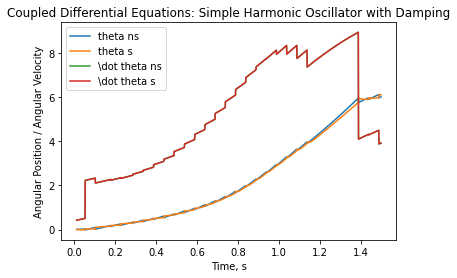

In [32]:
from scipy.integrate import solve_ivp # lsoda solver 

# # Model params
mu   = 2     # 0.1 ... 10
beta = 2    # 0.1 ... 10
phi  = -0.0525 # rad
l    = 1     # m

# Initial state vector
theta_ns_0 =  0.0   # swing leg   (ussually positive)
theta_s_0  =  0.0   # support leg
dot_theta_ns_0 = 0.4
dot_theta_s_0  = 2.0

switch_flag = False
last_switch_time = -1.
def dyn_sys(t, x):
    global switch_flag, last_switch_time
#     print(x)
    q = x.T[0]
#     print(x.T[0])

    ground_touched = touch_detector(q, phi)
    
#     if (switch_flag==False) and (t>0.6) and ( last_switch_time < 0 ):
#     if touch_detector(q, phi) and (t - last_switch_time) > 0.25:
    if ground_touched and (t - last_switch_time) > 0.05:
        print("zero crossing at " + str(t) + " with  q: " + str(q))
        
        switch_flag = True
        last_switch_time = t
    else:
        pass

    _M = M(q, mu=mu, beta=beta, phi=phi)
    _M_inv = np.linalg.inv( _M )
    _N = N(q, mu=mu, beta=beta)
    _g = g(q, mu=mu, beta=beta)

    a_inv = (1+beta)/l

    z = np.array([[q[2]],
                  [q[3]]])
#     z_dot = - _M_inv @ ( _N @ z + a_inv*_g ) 
    z_dot = np.linalg.solve( _M, -( _N @ z + a_inv*_g) )
    
#     if np.allclose(z_dot, solutions):
#         print("alarm!")

    return np.array([[z],
                     [z_dot]]).T

t_upper = 1.5
t_lower = 0.
t = np.linspace(t_lower, t_upper, 200)
initial_state = np.array([theta_ns_0, theta_s_0, dot_theta_ns_0, dot_theta_s_0])

# x' = f(t, x)
# solution = integrator(fun=dyn_sys, t0=t_lower, y0=initial_state, t_bound=t_upper, max_step=0.1, vectorized=True)

# collect data
t_values = []
q_ns_values = []
q_s_values  = []
q_ns_dot_values = []
q_s_dot_values  = []
alpha_values = [] 
test_values = []
zero_crossing_values = []

solution = integrator(fun=dyn_sys, y0=initial_state,
                      t0=t_lower, t_bound=t_upper,
                      max_step=0.001, rtol=1e-5, atol=1e-7,
                      vectorized=True)
while True:
    # get solution step state
    solution.step()
    
    # collect state stamps
    t_values.append(solution.t)
    q_ns_values.append(solution.y[0])
    q_s_values.append(solution.y[1])
    q_ns_dot_values.append(solution.y[2])
    q_s_dot_values.append(solution.y[2])
    
    # reconstruct alpha 
    alpha = alpha_calc(solution.y)
    alpha_values.append(alpha)
    
    # test record
    ttt = contact_estimator(solution.y, phi)
    test_values.append(ttt)
    
    # zero-crossing
    zcd = touch_detector(solution.y, phi)
    zero_crossing_values.append(zcd)
    
    # restart solver on step event
    if switch_flag == True:
        q = solution.y
        _W = W(q, mu=mu, beta=beta, phi=phi)
        q = (_W @ np.asarray([q]).T)
        q = np.asarray(q.T)[0]
        
        solution = integrator(fun=dyn_sys, y0=q,
                              t0=solution.t, t_bound=t_upper,
                              max_step=0.001, 
                              rtol=1e-5, atol=1e-7,
                              vectorized=True)
        switch_flag = False
        print('restarted at state: ', q)

    # break loop if solution is unstable
    if np.linalg.norm( solution.y ) > 80:
        break
        
    # break loop when modeling is finished
    if solution.status == 'finished':
        break

print( np.linalg.norm( solution.y ) ) 

plt.plot(t_values[10:-1], q_ns_values[10:-1], label='theta ns')
plt.plot(t_values[10:-1], q_s_values[10:-1],  label='theta s')
plt.plot(t_values[10:-1], q_ns_dot_values[10:-1], label='\dot theta ns')
plt.plot(t_values[10:-1], q_s_dot_values[10:-1],  label='\dot theta s')
# plt.plot(t_values, alpha_values, label='alpha')
# plt.plot(t, v_values, label='Velocity v')
plt.xlabel('Time, s')
plt.ylabel('Angular Position / Angular Velocity')
plt.legend()
plt.title('Coupled Differential Equations: Simple Harmonic Oscillator with Damping')
plt.show()

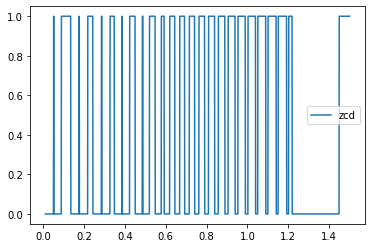

10.0


In [30]:
# plt.plot(t_values[10:-1], q_ns_values[10:-1], label='theta_ns')
# plt.plot(t_values[10:-1], test_values[10:-1], label='test')
plt.plot(t_values[10:-1], zero_crossing_values[10:-1], label='zcd')
# plt.plot(t_values[10:900], test_values[10:900], label='test')
plt.legend()
plt.show()
print(test_values[50])

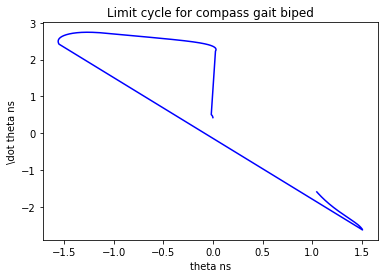

In [25]:
# plt.plot(q_s_values[10:-1], q_s_dot_values[10:-1], 'b-')
plt.plot(q_s_values[10:900], q_s_dot_values[10:900], 'b-')
plt.xlabel('theta ns')
plt.ylabel('\dot theta ns')
plt.title('Limit cycle for compass gait biped')
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import Video
 
class CompassBiped:
    
    def __init__(self): 
        self.state = np.zeros(4) # vector for current state [x y theta_s alpha]
        
        self.ground = ( [-3*np.cos(phi), 3*np.cos(phi)], [-3*np.sin(-phi), 3*np.sin(-phi)] )
        self.L1 = 1 # length of link 1 in m
        self.L2 = 1 # length of link 2 in m
        
        self.time_elapsed = 0
     
    def position(self):
        """Compute x,y position of the joints"""
        
        q_s = self.state[2]
        q_a = q_s - (np.pi - 2*self.state[3])
 
        x = np.cumsum([self.state[0],
                       self.L1 * np.sin(-q_s),
                       self.L2 * np.sin(-q_a)])
        y = np.cumsum([self.state[1],
                       self.L1 * np.cos(q_s),
                       self.L2 * np.cos(q_a)])
        return (x, y)
    
    def leg_s_position(self):
        q_s = self.state[2]
        q_a = q_s - (np.pi - 2*self.state[3])
 
        x = np.cumsum([self.state[0],
                       self.L1 * np.sin(-q_s)])
        y = np.cumsum([self.state[1],
                       self.L1 * np.cos(q_s)])
        return (x, y)
    
    def leg_ns_position(self):
        q_s = self.state[2]
        q_a = q_s - (np.pi - 2*self.state[3])
 
        x = np.array([self.state[0] + self.L1 * np.sin(-q_s),
                      self.state[0] + self.L1 * np.sin(-q_s) + self.L2 * np.sin(-q_a)])
        y = np.array([self.state[1] + self.L1 * np.cos(q_s),
                      self.state[1] + self.L1 * np.cos(q_s) + self.L2 * np.cos(q_a)])
        return (x, y)
 
    def step(self, q_s, alpha, switch, dt):
        """Load and update the state"""
        self.state[2] = q_s
        self.state[3] = alpha
        
        if switch:
            print('switch!: ', switch)
            x, y = self.position()
            self.state[0] = x[-1]
            self.state[1] = y[-1]
            
        self.time_elapsed += dt
 
# set up initial state and global variables
robot = CompassBiped()
dt = 1./30 # 30 fps
 
# set up figure and animation
fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(111, autoscale_on=False,
                     xlim=(-3, 3), ylim=(-0.5, 2))
ax.grid()
 
leg_s,    = ax.plot([], [], 'ro-',  lw=4, mew=5)
leg_ns,   = ax.plot([], [], 'g',   lw=4, mew=5)
ground,   = ax.plot([], [], 'b-',  lw=6, mew=5)
time_text  = ax.text(0.02, 0.95, '', transform=ax.transAxes)
q_ns_text  = ax.text(0.02, 0.90, '', transform=ax.transAxes)
q_s_text   = ax.text(0.02, 0.85, '', transform=ax.transAxes)
alpha_text = ax.text(0.02, 0.80, '', transform=ax.transAxes)

mu_text   = ax.text(0.84, 0.95, '', transform=ax.transAxes)
beta_text = ax.text(0.84, 0.90, '', transform=ax.transAxes)
phi_text  = ax.text(0.84, 0.85, '', transform=ax.transAxes)
theta_ns_0_text = ax.text(0.84, 0.80, '', transform=ax.transAxes)
theta_s_0_text  = ax.text(0.84, 0.75, '', transform=ax.transAxes)
dot_theta_ns_0_text = ax.text(0.84, 0.70, '', transform=ax.transAxes)
dot_theta_s_0_text  = ax.text(0.84, 0.65, '', transform=ax.transAxes)
 
def init():
    """initialize animation"""
    ground.set_data([], [])
    leg_s.set_data([], [])
    leg_ns.set_data([], [])
    
    # biped state 
    time_text.set_text('')
    q_ns_text.set_text('')
    q_s_text.set_text('')
    alpha_text.set_text('')
    
    # biped params 
    mu_text.set_text('mu = %.2f' %mu)
    beta_text.set_text('beta = %.2f' %beta)
    phi_text.set_text('phi = %.2f' %phi)
    theta_ns_0_text.set_text('q_ns_0 = %.2f' %theta_ns_0)
    theta_s_0_text.set_text('q_s_0  = %.2f' %theta_s_0)
    dot_theta_ns_0_text.set_text('dot_q_ns_0  = %.2f' %dot_theta_ns_0)
    dot_theta_s_0_text.set_text('dot_q_s_0 = %.2f' %dot_theta_s_0)
    
    print(robot.position())
    
    return ground, leg_s, leg_ns, time_text, q_ns_text, q_s_text, alpha_text
 
def animate(i):
    """perform animation step"""
    global robot, dt
    
#     if i>0:
#         dt = t_values[i] - t_values[i-1]
    dt = 1./30
    robot.step(q_s_values[i], alpha_values[i], zero_crossing_values[i], dt)
    
    ground.set_data(*robot.ground)
    leg_s.set_data(*robot.leg_s_position())
    leg_ns.set_data(*robot.leg_ns_position())
    
    # biped state 
    time_text.set_text('time = %.2f' % t_values[i])
    q_ns_text.set_text('theta_ns = %.4f' % q_ns_values[i])
    q_s_text.set_text('theta_s = %.4f' % q_s_values[i])
    alpha_text.set_text('alpha = %.4f' % alpha_values[i])
    
    # biped params
    
    return ground, leg_s, leg_ns, time_text, q_ns_text, q_s_text, alpha_text
 
# frames=None for matplotlib 1.3
ani = animation.FuncAnimation(fig, animate, frames=None,
                              interval=3, blit=True, 
                              init_func=init)
 
# save the video in mp4 format.
# requires either mencoder or ffmpeg to be installed
ani.save('videos/playground_2.mp4', fps=10, 
        extra_args=['-vcodec', 'libx264'])
 
Video('videos/playground_2.mp4', height=300, embed=True)